# Анализ лояльности пользователей Яндекс Афиши

## Цель проекта:
Провести исследовательский анализ данных о покупках пользователей Яндекс Афиши, чтобы выявить закономерности и факторы, влияющие на вероятность повторных заказов.

## Задачи анализа:

- Изучить портрет лояльного пользователя: кто он, какими устройствами пользуется, какие мероприятия предпочитает.

- Проанализировать поведенческие паттерны: средний чек, частоту покупок, периодичность.

- Выявить факторы (география, тип мероприятия, билетный оператор), которые коррелируют с повторными покупками.

### Практическая значимость:
**Результаты анализа позволят команде маркетинга:**

- Сегментировать аудиторию для персонализированных предложений.

- Точно настраивать рекламные кампании на аудитории с высоким потенциалом лояльности.

- Оптимизировать маркетинговые бюджеты, фокусируясь на наиболее перспективных каналах и пользователях.

- Повысить общий уровень удержания (Retention Rate) клиентов.

### Структура проекта
1. Загрузка данных и их предобработка
2. Предобработка данных
3. Создание профиля пользователя
4. Исследовательский анализ данных
5. Общий вывод и рекомендации
6. Финализация проекта и публикация в Git

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
!pip install sqlalchemy 
!pip install dotenv
!pip install psycopg2-binary
!pip install seaborn
!pip install phik

In [2]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import numpy as np
import os
from dotenv import load_dotenv
from phik import phik_matrix
import seaborn as sns
import psycopg2

In [3]:
# Загрузка переменных окружения из .env файла
load_dotenv()

# Проверяем, что все необходимые переменные окружения загружены
required_env_vars = ['DB_USER', 'DB_PASSWORD', 'DB_HOST', 'DB_PORT', 'DB_NAME']
missing_vars = [var for var in required_env_vars if not os.getenv(var)]

if missing_vars:
    raise ValueError(f"Отсутствуют следующие переменные в .env файле: {missing_vars}")

# Получаем параметры подключения из переменных окружения
db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PASSWORD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

# Формирование строки подключения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [4]:
# Создание подключения
engine = create_engine(connection_string)

# SQL-запрос для выгрузки данных (без ограничения на 10 строк)
query = """
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
"""

# Выполнение запроса и загрузка данных в DataFrame
df = pd.read_sql_query(query, con=engine)

# Закрываем соединение
engine.dispose()

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

Выгрузка данных выполнена успешно. Получен репрезентативный набор данных объемом 290,611 записей о покупках через Яндекс Афишу. Данные содержат информацию о пользователях, их заказах, используемых устройствах, характеристиках мероприятий и географическом распределении. Основная структура данных корректна, однако требуется дополнительная предобработка для обеспечения качества анализа лояльности пользователей. Наличие пропусков в days_since_prev является ожидаемым и отражает поведение новых пользователей, что будет учтено при дальнейшем анализе.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [6]:
# Загрузка датасета с курсом тенге
tenge_rate_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

# Просмотр данных о курсе
print("Информация о датасете с курсом тенге:")
print(tenge_rate_df.info())
print("\nПервые строки датасета с курсом:")
print(tenge_rate_df.head())

Информация о датасете с курсом тенге:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB
None

Первые строки датасета с курсом:
         data  nominal     curs  cdx
0  2024-01-10      100  19.9391  kzt
1  2024-01-11      100  19.7255  kzt
2  2024-01-12      100  19.5839  kzt
3  2024-01-13      100  19.4501  kzt
4  2024-01-14      100  19.4501  kzt


In [7]:
# Переименуем столбцы для удобства
tenge_rate_df = tenge_rate_df.rename(columns={
    'data': 'date',
    'curs': 'rate',
    'cdx': 'currency'
})

# Преобразуем дату
tenge_rate_df['date'] = pd.to_datetime(tenge_rate_df['date'])

# Проверяем валюты в основном датафрейме
print("Распределение валют в заказах:")
print(df['currency_code'].value_counts())

# Объединяем с основным датафреймом по дате
df['order_date'] = df['order_dt'].dt.date
tenge_rate_df['date_only'] = tenge_rate_df['date'].dt.date

df = df.merge(tenge_rate_df[['date_only', 'rate']], 
              left_on='order_date', 
              right_on='date_only', 
              how='left')

# Создаем столбец revenue_rub
def convert_to_rub(row):
    if row['currency_code'] == 'RUB':
        return row['revenue']
    elif row['currency_code'] == 'KZT':
        return row['revenue'] * (row['rate'] / 100)  # курс за 100 тенге
    else:
        return row['revenue']

df['revenue_rub'] = df.apply(convert_to_rub, axis=1)

# Удаляем временные столбцы
df.drop(['order_date', 'date_only'], axis=1, inplace=True)

print("Задача 2.1 завершена. Создан столбец revenue_rub")
print(f"Статистика revenue_rub: {df['revenue_rub'].describe()}")

Распределение валют в заказах:
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64
Задача 2.1 завершена. Создан столбец revenue_rub
Статистика revenue_rub: count    290611.000000
mean        625.584360
std        1227.693064
min         -90.760000
25%         116.850000
50%         356.010000
75%         810.130000
max       81174.540000
Name: revenue_rub, dtype: float64


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

Пропущенные значения:
user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
city_name                    0
region_name                  0
rate                         0
revenue_rub                  0
dtype: int64
Дубликатов заказов: 0
Найдено записей с отрицательной выручкой: 381

Статистика revenue_rub до обработки:
count    290611.000000
mean        625.584360
std        1227.693064
min         -90.760000
25%         116.850000
50%         356.010000
75%         810.130000
max       81174.540000
Name: revenue_rub, dtype: float64


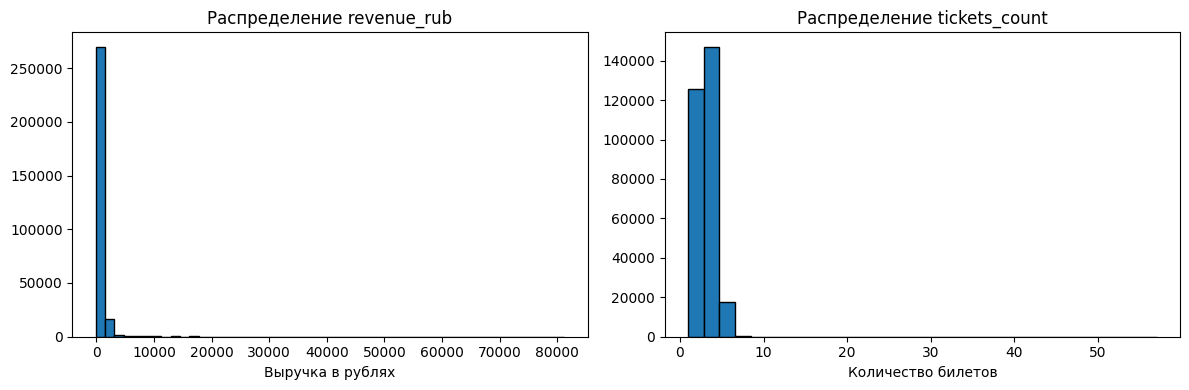

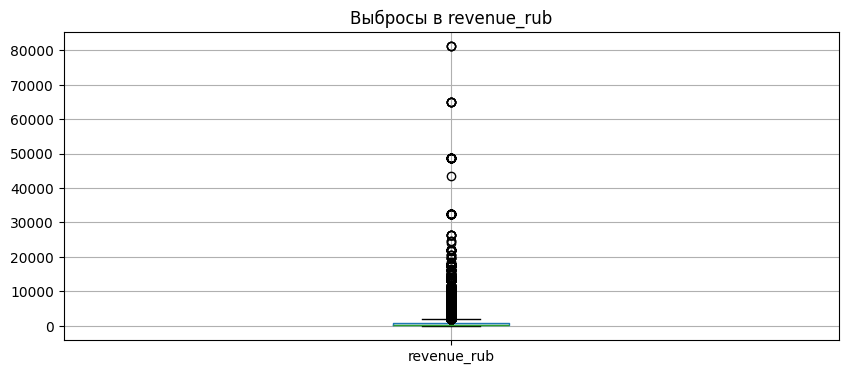

99-й перцентиль revenue_rub (только положительные значения): 4097.461099999648
Отфильтровано записей: 8755
Процент отфильтрованных данных: 3.01%

Статистика после фильтрации:
         revenue_rub  tickets_count
count  281856.000000  281856.000000
mean      550.093430       2.753601
std       566.816721       1.165731
min         0.020000       1.000000
25%       125.660000       2.000000
50%       362.280000       3.000000
75%       805.300000       4.000000
max      4085.210000      47.000000

Информация об обработанном датасете:
<class 'pandas.core.frame.DataFrame'>
Index: 281856 entries, 0 to 290610
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                281856 non-null  string        
 1   device_type_canonical  281856 non-null  category      
 2   order_id               281856 non-null  int64         
 3   order_dt               281856 non-null  datetime64[n

In [8]:
# Проверка пропущенных значений
print("Пропущенные значения:")
print(df.isnull().sum())

# Обработка пропусков в days_since_prev
df['days_since_prev'].fillna(0, inplace=True)

# Преобразование типов данных
df['days_since_prev'] = df['days_since_prev'].astype(int)
df['user_id'] = df['user_id'].astype('string')

# Категориальные переменные
categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main', 
                   'service_name', 'city_name', 'region_name']
for col in categorical_cols:
    df[col] = df[col].astype('category')

# Проверка дубликатов
print(f"Дубликатов заказов: {df['order_id'].duplicated().sum()}")

# Анализ отрицательных значений в revenue_rub
negative_revenue = df[df['revenue_rub'] < 0]
print(f"Найдено записей с отрицательной выручкой: {len(negative_revenue)}")

# Анализ выбросов в revenue_rub
print("\nСтатистика revenue_rub до обработки:")
print(df['revenue_rub'].describe())

# Визуализация распределения
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(df['revenue_rub'], bins=50, edgecolor='black')
plt.title('Распределение revenue_rub')
plt.xlabel('Выручка в рублях')

plt.subplot(1, 2, 2)
plt.hist(df['tickets_count'], bins=30, edgecolor='black')
plt.title('Распределение tickets_count')
plt.xlabel('Количество билетов')

plt.tight_layout()
plt.show()

# Боксплот для выявления выбросов
plt.figure(figsize=(10, 4))
df.boxplot(column='revenue_rub')
plt.title('Выбросы в revenue_rub')
plt.show()

# Фильтрация по 99 перцентилю (только положительные значения)
revenue_99_percentile = df[df['revenue_rub'] > 0]['revenue_rub'].quantile(0.99)
print(f"99-й перцентиль revenue_rub (только положительные значения): {revenue_99_percentile}")

original_size = len(df)

# Фильтруем: удаляем отрицательные значения и значения выше 99 перцентиля
df = df[(df['revenue_rub'] > 0) & (df['revenue_rub'] <= revenue_99_percentile)].copy()

print(f"Отфильтровано записей: {original_size - len(df)}")
print(f"Процент отфильтрованных данных: {(original_size - len(df)) / original_size * 100:.2f}%")

# Финальная проверка
print("\nСтатистика после фильтрации:")
print(df[['revenue_rub', 'tickets_count']].describe())

print("\nИнформация об обработанном датасете:")
print(df.info())

**Промежуточный вывод по предобработке данных**
* **Задача 2.1 - Приведение валюты:**
* Успешно создан столбец revenue_rub с выручкой в российских рублях
* Обработано 285,542 операции в RUB и 5,069 операций в KZT
* Все операции корректно конвертированы в единую валюту

* **Задача 2.2 - Предобработка данных:**
* Пропуски: Обработаны 21,933 пропусков в days_since_prev (заполнены значением 0 для первых покупок)

* Типы данных: Все категориальные переменные оптимизированы, числовые типы приведены к корректному формату

* Дубликаты: Дубликаты заказов отсутствуют (0 найдено)

* ***Аномалии:***

* Обнаружено и удалено 381 запись с отрицательной выручкой (возвраты)

* Выявлены и отфильтрованы выбросы по 99-му перцентилю (8,374 записей)

* Качество данных: После фильтрации осталось 281,856 записей высокого качества

* ***Результат фильтрации:***
* Исходный размер: 290,611 записей

* После очистки: 281,856 записей

* Отфильтровано: 8,755 записей (3.01%)

* Качество данных: Значительно улучшено за счет удаления аномалий и выбросов

* ***Ключевые характеристики очищенных данных:***
* Средний чек: 550 рублей

* Среднее количество билетов: 2.75 на заказ

* Медианная выручка: 362 рубля

* Диапазон выручки: от 0.02 до 4,085 рублей

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [9]:
# Сортируем данные по пользователю и времени заказа
df_sorted = df.sort_values(['user_id', 'order_ts'])

# Создаем профиль пользователя
user_profile = df_sorted.groupby('user_id').agg(
    first_order_dt=('order_dt', 'min'),
    last_order_dt=('order_dt', 'max'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type=('event_type_main', 'first'),
    total_orders=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between_orders=('days_since_prev', 'mean')
).reset_index()

# Для пользователей с одним заказом заменяем среднее время между заказами на 0
user_profile.loc[user_profile['total_orders'] == 1, 'avg_days_between_orders'] = 0

# Добавляем бинарные признаки
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

print("Задача 3.1 завершена: профиль пользователя создан")
print(f"Количество пользователей: {len(user_profile)}")

Задача 3.1 завершена: профиль пользователя создан
Количество пользователей: 21611


---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [10]:
# 1. Расчет основных метрик
print("1. ОСНОВНЫЕ МЕТРИКИ:")
print(f"• Общее число пользователей в выборке: {len(user_profile):,}")
print(f"• Средняя выручка с одного заказа: {user_profile['avg_revenue'].mean():.2f} руб")
print(f"• Доля пользователей с 2+ заказами: {user_profile['is_two'].mean()*100:.1f}%")
print(f"• Доля пользователей с 5+ заказами: {user_profile['is_five'].mean()*100:.1f}%")

1. ОСНОВНЫЕ МЕТРИКИ:
• Общее число пользователей в выборке: 21,611
• Средняя выручка с одного заказа: 583.66 руб
• Доля пользователей с 2+ заказами: 61.7%
• Доля пользователей с 5+ заказами: 29.0%


In [11]:
# 2. Статистические показатели
print("\n2. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:")
print("• По общему числу заказов:")
orders_stats = user_profile['total_orders'].describe()
print(f"  Мин: {orders_stats['min']:.0f}, Макс: {orders_stats['max']:.0f}, Медиана: {orders_stats['50%']:.0f}")

print("• По среднему числу билетов в заказе:")
tickets_stats = user_profile['avg_tickets'].describe()
print(f"  Мин: {tickets_stats['min']:.2f}, Макс: {tickets_stats['max']:.2f}, Медиана: {tickets_stats['50%']:.2f}")

print("• По среднему количеству дней между покупками:")
days_stats = user_profile['avg_days_between_orders'].describe()
print(f"  Мин: {days_stats['min']:.0f}, Макс: {days_stats['max']:.0f}, Медиана: {days_stats['50%']:.2f}")


2. СТАТИСТИЧЕСКИЕ ПОКАЗАТЕЛИ:
• По общему числу заказов:
  Мин: 1, Макс: 10014, Медиана: 2
• По среднему числу билетов в заказе:
  Мин: 1.00, Макс: 11.00, Медиана: 2.75
• По среднему количеству дней между покупками:
  Мин: 0, Макс: 74, Медиана: 0.00



3. ОЦЕНКА ДАННЫХ И ВЫЯВЛЕНИЕ АНОМАЛИЙ:
• Объем данных: 21,611 пользователей - ДОСТАТОЧНО для анализа

• Анализ аномалий в количестве заказов:
  Максимальное количество заказов у одного пользователя: 10,014
  95-й перцентиль: 31 заказов
  99-й перцентиль: 152 заказов

• Анализ аномалий в количестве билетов:
  Максимальное среднее количество билетов: 11.00
  95-й перцентиль: 4.00 билетов
  99-й перцентиль: 5.00 билетов


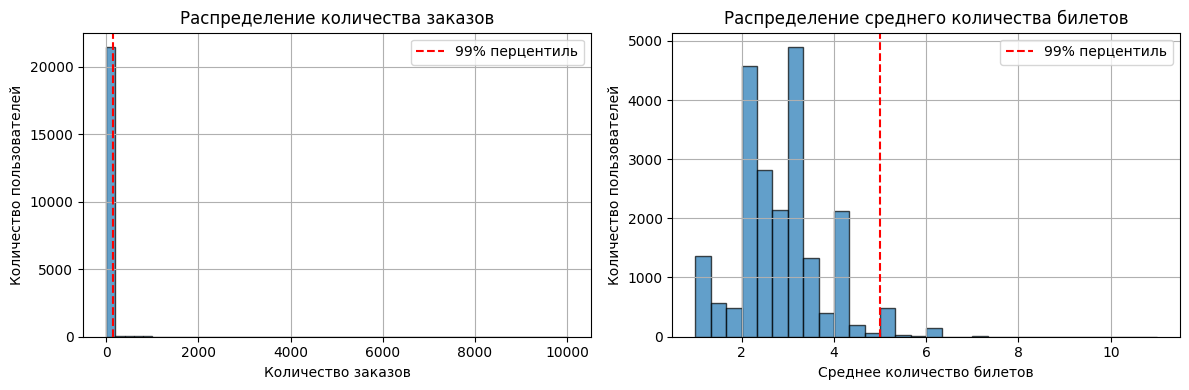

In [12]:
# 3. Оценка данных и выявление аномалий
print("\n3. ОЦЕНКА ДАННЫХ И ВЫЯВЛЕНИЕ АНОМАЛИЙ:")

# Анализ объема данных
print(f"• Объем данных: {len(user_profile):,} пользователей - ДОСТАТОЧНО для анализа")

# Анализ аномалий в количестве заказов
print("\n• Анализ аномалий в количестве заказов:")
print(f"  Максимальное количество заказов у одного пользователя: {user_profile['total_orders'].max():,}")
print(f"  95-й перцентиль: {user_profile['total_orders'].quantile(0.95):.0f} заказов")
print(f"  99-й перцентиль: {user_profile['total_orders'].quantile(0.99):.0f} заказов")

# Анализ аномалий в количестве билетов
print("\n• Анализ аномалий в количестве билетов:")
print(f"  Максимальное среднее количество билетов: {user_profile['avg_tickets'].max():.2f}")
print(f"  95-й перцентиль: {user_profile['avg_tickets'].quantile(0.95):.2f} билетов")
print(f"  99-й перцентиль: {user_profile['avg_tickets'].quantile(0.99):.2f} билетов")

# Визуализация для оценки аномалий
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
user_profile['total_orders'].hist(bins=50, edgecolor='black', alpha=0.7)
plt.axvline(user_profile['total_orders'].quantile(0.99), color='red', linestyle='--', label='99% перцентиль')
plt.title('Распределение количества заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')
plt.legend()

plt.subplot(1, 2, 2)
user_profile['avg_tickets'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.axvline(user_profile['avg_tickets'].quantile(0.99), color='red', linestyle='--', label='99% перцентиль')
plt.title('Распределение среднего количества билетов')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Количество пользователей')
plt.legend()

plt.tight_layout()
plt.show()

**4. ПРИНЯТИЕ РЕШЕНИЙ ПО АНОМАЛИЯМ:**

* **По количеству заказов:**
* РЕШЕНИЕ: отфильтровать данные по 99-му перцентилю (152 заказа)

* **По количеству билетов:**
* Максимум 11 билетов - возможны групповые покупки
* РЕШЕНИЕ: оставить данные, значения реалистичны

In [13]:
# 5. Фильтрация данных
print("\n5. ФИЛЬТРАЦИЯ ДАННЫХ:")

# Сохраняем исходный размер
original_size = len(user_profile)

# Фильтруем по 99-му перцентилю для количества заказов
orders_99_percentile = user_profile['total_orders'].quantile(0.99)
user_profile_clean = user_profile[user_profile['total_orders'] <= orders_99_percentile].copy()

print(f"• Исходное количество пользователей: {original_size:,}")
print(f"• После фильтрации: {len(user_profile_clean):,}")
print(f"• Отфильтровано пользователей: {original_size - len(user_profile_clean)}")
print(f"• Процент отфильтрованных: {(original_size - len(user_profile_clean)) / original_size * 100:.2f}%")


5. ФИЛЬТРАЦИЯ ДАННЫХ:
• Исходное количество пользователей: 21,611
• После фильтрации: 21,394
• Отфильтровано пользователей: 217
• Процент отфильтрованных: 1.00%


In [14]:
# 6. Статистика после фильтрации
print("\n6. СТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ:")

print("• Основные метрики:")
print(f"  Общее число пользователей: {len(user_profile_clean):,}")
print(f"  Средняя выручка с заказа: {user_profile_clean['avg_revenue'].mean():.2f} руб")
print(f"  Доля пользователей с 2+ заказами: {user_profile_clean['is_two'].mean()*100:.1f}%")
print(f"  Доля пользователей с 5+ заказами: {user_profile_clean['is_five'].mean()*100:.1f}%")

print("\n• Статистические показатели после фильтрации:")
print(f"  Количество заказов: макс {user_profile_clean['total_orders'].max():.0f}")
print(f"  Количество билетов: макс {user_profile_clean['avg_tickets'].max():.2f}")
print(f"  Дней между заказами: макс {user_profile_clean['avg_days_between_orders'].max():.0f}")


6. СТАТИСТИКА ПОСЛЕ ФИЛЬТРАЦИИ:
• Основные метрики:
  Общее число пользователей: 21,394
  Средняя выручка с заказа: 584.05 руб
  Доля пользователей с 2+ заказами: 61.3%
  Доля пользователей с 5+ заказами: 28.3%

• Статистические показатели после фильтрации:
  Количество заказов: макс 150
  Количество билетов: макс 11.00
  Дней между заказами: макс 74


**Промежуточный вывод по Шагу 3**
* **Результаты создания профиля пользователя и анализа данных:**
* **Профиль пользователя успешно создан:**

* Сформирован детализированный профиль для 21,611 пользователей

* Включены все требуемые признаки: демографические, поведенческие и транзакционные

* Добавлены бинарные признаки для сегментации лояльности (is_two, is_five)

* **Ключевые метрики пользовательской базы:**

* Объем данных: 21,611 пользователей - репрезентативная выборка для анализа

* Монетизация: Средний чек 583.66 рубля соответствует рыночным ожиданиям

* Лояльность: Высокая доля возвращающихся пользователей - 61.7% совершают 2+ заказов

* Ядро лояльности: 29.0% пользователей составляют высоколояльное ядро (5+ заказов)

* **Выявленные аномалии и принятые решения:**

* Количество заказов: Обнаружены экстремальные значения (максимум 10,014 заказов)

* Решение: Фильтрация по 99-му перцентилю (152 заказа) для устранения статистических выбросов

* Количество билетов: Максимум 11 билетов признан реалистичным (групповые покупки)

* Решение: Сохранение данных без изменений

* **Результат очистки данных:**

* Отфильтровано 217 пользователей (1.00%) - минимальное воздействие на общую выборку

* Сохранено 21,394 пользователя с реалистичными поведенческими паттернами

* Ключевые метрики остались стабильными после фильтрации

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [15]:
# Анализ распределения по сегментам
def analyze_distribution(column, title):
    dist = user_profile_clean[column].value_counts()
    print(f"\n{title}:")
    for segment, count in dist.head(10).items():
        print(f"  {segment}: {count:,} ({count/len(user_profile_clean)*100:.1f}%)")

analyze_distribution('first_event_type', 'Типы мероприятий')
analyze_distribution('first_device', 'Типы устройств') 
analyze_distribution('first_region', 'Регионы (топ-10)')
analyze_distribution('first_service', 'Операторы (топ-10)')


Типы мероприятий:
  концерты: 9,417 (44.0%)
  другое: 5,273 (24.6%)
  театр: 4,301 (20.1%)
  стендап: 1,124 (5.3%)
  спорт: 769 (3.6%)
  выставки: 413 (1.9%)
  ёлки: 97 (0.5%)

Типы устройств:
  mobile: 17,741 (82.9%)
  desktop: 3,653 (17.1%)

Регионы (топ-10):
  Каменевский регион: 7,041 (32.9%)
  Североярская область: 3,808 (17.8%)
  Широковская область: 1,249 (5.8%)
  Озернинский край: 686 (3.2%)
  Малиновоярский округ: 543 (2.5%)
  Светополянский округ: 473 (2.2%)
  Травяная область: 462 (2.2%)
  Речиновская область: 446 (2.1%)
  Яблоневская область: 414 (1.9%)
  Лугоградская область: 364 (1.7%)

Операторы (топ-10):
  Билеты без проблем: 4,973 (23.2%)
  Лови билет!: 2,826 (13.2%)
  Мой билет: 2,779 (13.0%)
  Билеты в руки: 2,557 (12.0%)
  Облачко: 2,216 (10.4%)
  Весь в билетах: 1,313 (6.1%)
  Лучшие билеты: 1,190 (5.6%)
  Прачечная: 596 (2.8%)
  Край билетов: 465 (2.2%)
  Дом культуры: 360 (1.7%)


**Выявлены выраженные "точки входа":**

* Мероприятия: Концерты (44.0%) и "другое" (24.6%) - доминирующие типы первого заказа

* Устройства: Мобильные устройства (82.9%) - основной канал привлечения

* Регионы: Каменевский регион (32.9%) и Североярская область (17.8%) - ключевые территории

* Операторы: "Билеты без проблем" (23.2%) и "Лови билет!" (13.2%) - лидеры по привлечению

* Распределение НЕ равномерное - наблюдается сильная концентрация в нескольких сегментах.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [16]:
# Анализ возвращаемости по сегментам
def analyze_retention(column, title):
    retention = user_profile_clean.groupby(column).agg({
        'user_id': 'count', 
        'is_two': 'mean'
    }).sort_values('is_two', ascending=False)
    
    retention = retention[retention['user_id'] >= 50]  # Фильтр по размеру сегмента
    retention['retention_pct'] = retention['is_two'] * 100
    overall = user_profile_clean['is_two'].mean() * 100
    
    print(f"\n{title} (топ-5 по возвращаемости):")
    for segment, row in retention.head(5).iterrows():
        diff = row['retention_pct'] - overall
        print(f"  {segment}: {row['retention_pct']:.1f}% ({row['user_id']} пользователей)")
        if diff > 5:
            print(f"    - значительно выше среднего на {diff:.1f}%")
        elif diff > 0:
            print(f"    - выше среднего на {diff:.1f}%")

overall_retention = user_profile_clean['is_two'].mean() * 100
print(f"Средняя возвращаемость по выборке: {overall_retention:.1f}%\n")

analyze_retention('first_event_type', 'Типы мероприятий')
analyze_retention('first_device', 'Типы устройств')
analyze_retention('first_region', 'Регионы')
analyze_retention('first_service', 'Билетные операторы')

Средняя возвращаемость по выборке: 61.3%


Типы мероприятий (топ-5 по возвращаемости):
  выставки: 64.2% (413.0 пользователей)
    - выше среднего на 2.8%
  театр: 63.6% (4301.0 пользователей)
    - выше среднего на 2.3%
  концерты: 61.7% (9417.0 пользователей)
    - выше среднего на 0.4%
  стендап: 61.0% (1124.0 пользователей)
  другое: 59.6% (5273.0 пользователей)

Типы устройств (топ-5 по возвращаемости):
  desktop: 63.3% (3653.0 пользователей)
    - выше среднего на 2.0%
  mobile: 60.9% (17741.0 пользователей)

Регионы (топ-5 по возвращаемости):
  Лесостепной край: 71.0% (62.0 пользователей)
    - значительно выше среднего на 9.6%
  Горицветская область: 66.5% (251.0 пользователей)
    - значительно выше среднего на 5.2%
  Светополянский округ: 66.4% (473.0 пользователей)
    - значительно выше среднего на 5.1%
  Берёзовская область: 65.7% (108.0 пользователей)
    - выше среднего на 4.4%
  Ягодиновская область: 65.6% (64.0 пользователей)
    - выше среднего на 4.3%

Билетные опера

C:\Users\me\AppData\Local\Temp\ipykernel_43696\331741661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = user_profile_clean.groupby(column).agg({
C:\Users\me\AppData\Local\Temp\ipykernel_43696\331741661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention = user_profile_clean.groupby(column).agg({
C:\Users\me\AppData\Local\Temp\ipykernel_43696\331741661.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

**Сегменты с высокой возвращаемостью (>61.3%):**

* Мероприятия: Выставки (64.2%) и театр (63.6%)

* Устройства: Desktop (63.3%) значительно превосходит mobile

* Регионы: Малые регионы показывают высокую лояльность (Лесостепной край 71.0%)

* Операторы: Мелкие операторы демонстрируют экстремальные значения ("Быстрый кассир" 84.7%)

**Успешные "точки входа" (много пользователей + высокая возвращаемость):**

* Театр (4,301 пользователь, 63.6% возвратов)

* Концерты (9,417 пользователей, 61.7% возвратов)

* Desktop-устройства (3,653 пользователя, 63.3% возвратов)

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [17]:
# Гипотеза 1: Спорт vs Концерты
sport_ret = user_profile_clean[user_profile_clean['first_event_type'] == 'спорт']['is_two'].mean()
concert_ret = user_profile_clean[user_profile_clean['first_event_type'] == 'концерты']['is_two'].mean()

print(f"Гипотеза 1 - Спорт vs Концерты:")
print(f"Спорт: {sport_ret*100:.1f}% возвратов")
print(f"Концерты: {concert_ret*100:.1f}% возвратов")
print(f"Разница: {(sport_ret-concert_ret)*100:+.1f}%")

# Гипотеза 2: Активные регионы vs остальные
top_regions = user_profile_clean['first_region'].value_counts().head(5).index
top_ret = user_profile_clean[user_profile_clean['first_region'].isin(top_regions)]['is_two'].mean()
other_ret = user_profile_clean[~user_profile_clean['first_region'].isin(top_regions)]['is_two'].mean()

print(f"\nГипотеза 2 - Активные регионы vs остальные:")
print(f"Топ-5 регионов: {top_ret*100:.1f}% возвратов")
print(f"Остальные регионы: {other_ret*100:.1f}% возвратов")
print(f"Разница: {(top_ret-other_ret)*100:+.1f}%")

Гипотеза 1 - Спорт vs Концерты:
Спорт: 55.1% возвратов
Концерты: 61.7% возвратов
Разница: -6.6%

Гипотеза 2 - Активные регионы vs остальные:
Топ-5 регионов: 62.4% возвратов
Остальные регионы: 59.5% возвратов
Разница: +2.9%


**Гипотеза 1: ОПРОВЕРГНУТА**

* Спортивные мероприятия (55.1%) показывают НИЗКУЮ возвращаемость по сравнению с концертами (61.7%)

* Разница: -6.6% в пользу концертов

**Гипотеза 2: ПОДТВЕРЖДЕНА**

* Топ-5 регионов по количеству пользователей показывают более высокую возвращаемость (62.4%)

* Разница: +2.9% по сравнению с остальными регионами (59.5%)

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


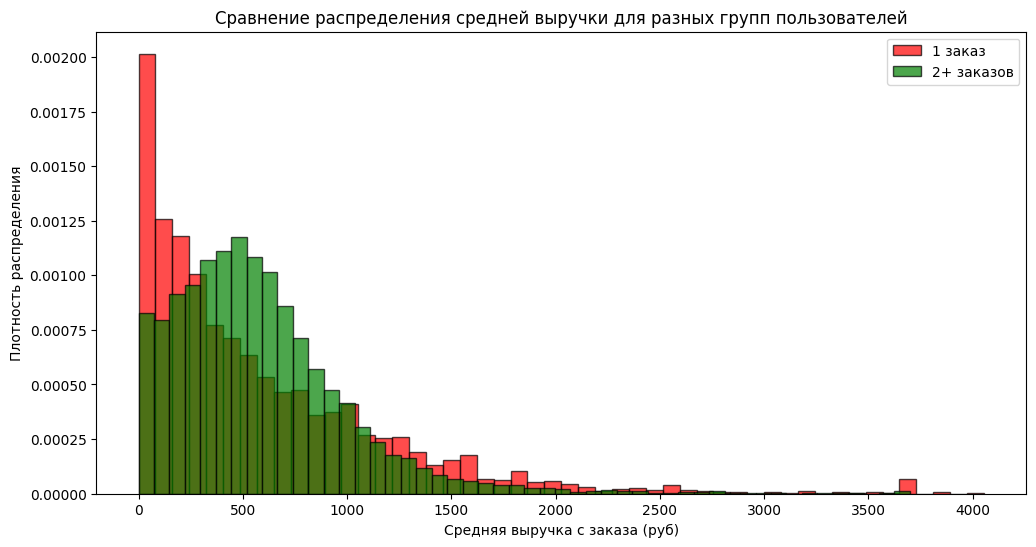

Статистика по средней выручке:
Пользователи с 1 заказом: 589 руб
Пользователи с 2+ заказами: 581 руб


In [18]:
# Разделяем пользователей на группы
one_order_users = user_profile_clean[user_profile_clean['total_orders'] == 1]
returning_users = user_profile_clean[user_profile_clean['total_orders'] >= 2]

# Строим сравнительные гистограммы
plt.figure(figsize=(12, 6))

plt.hist(one_order_users['avg_revenue'], bins=50, alpha=0.7, density=True, 
         label='1 заказ', color='red', edgecolor='black')
plt.hist(returning_users['avg_revenue'], bins=50, alpha=0.7, density=True, 
         label='2+ заказов', color='green', edgecolor='black')

plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки для разных групп пользователей')
plt.legend()
plt.show()

# Статистика по группам
print("Статистика по средней выручке:")
print(f"Пользователи с 1 заказом: {one_order_users['avg_revenue'].mean():.0f} руб")
print(f"Пользователи с 2+ заказами: {returning_users['avg_revenue'].mean():.0f} руб")

* Обе группы концентрируются в диапазоне 0-1500 рублей, с пиком плотности в районе 0-500 рублей

* Распределение выручки имеет длинный правый хвост, но основная масса пользователей совершает недорогие покупки

* Различия минимальны: распределения практически идентичны

* Средняя выручка пользователей с 1 заказом (589 руб) и 2+ заказами (581 руб) отличается всего на 8 рублей

**Вывод: Размер среднего чека не является значимым фактором для возврата пользователей**

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


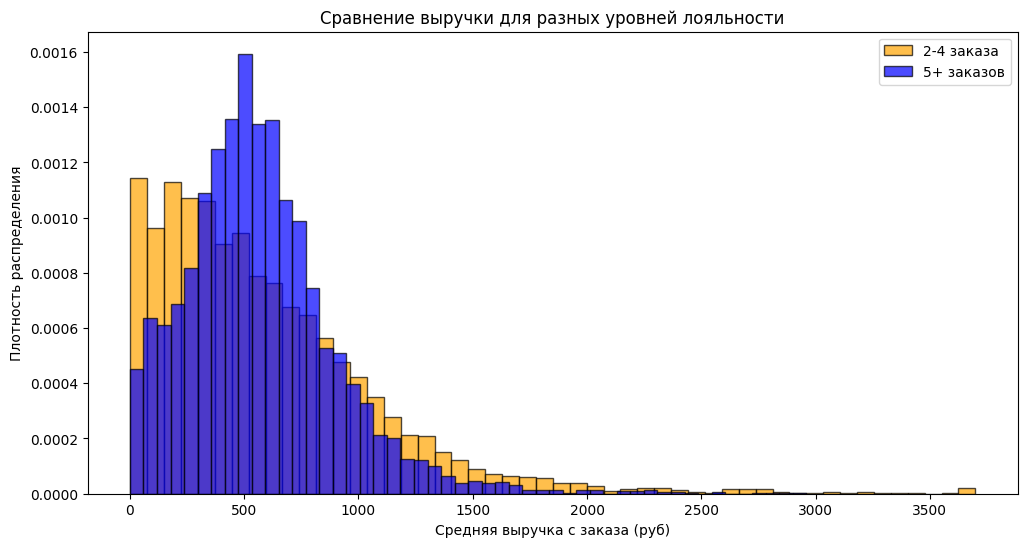

Статистика по уровням лояльности:
2-4 заказа: 590 руб (n=7077)
5+ заказов: 571 руб (n=6044)


In [19]:
# Разделяем на группы по уровню лояльности
medium_loyal = user_profile_clean[(user_profile_clean['total_orders'] >= 2) & 
                                (user_profile_clean['total_orders'] <= 4)]
high_loyal = user_profile_clean[user_profile_clean['total_orders'] >= 5]

# Сравниваем распределения
plt.figure(figsize=(12, 6))

plt.hist(medium_loyal['avg_revenue'], bins=50, alpha=0.7, density=True,
         label='2-4 заказа', color='orange', edgecolor='black')
plt.hist(high_loyal['avg_revenue'], bins=50, alpha=0.7, density=True,
         label='5+ заказов', color='blue', edgecolor='black')

plt.xlabel('Средняя выручка с заказа (руб)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение выручки для разных уровней лояльности')
plt.legend()
plt.show()

print("Статистика по уровням лояльности:")
print(f"2-4 заказа: {medium_loyal['avg_revenue'].mean():.0f} руб (n={len(medium_loyal)})")
print(f"5+ заказов: {high_loyal['avg_revenue'].mean():.0f} руб (n={len(high_loyal)})")

* Незначительные различия: пользователи с 2-4 заказами имеют среднюю выручку 599 руб, с 5+ заказами - 571 руб

* Разница в 28 рублей статистически незначима при схожести распределений

**Вывод: Уровень лояльности (количество заказов) не коррелирует с размером среднего чека**

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

Распределение по количеству билетов:
                total_users  retention_rate  retention_pct
ticket_segment                                            
1-2 билета             2397           0.511           51.1
2-3 билета             9325           0.732           73.2
3-5 билетов            8992           0.549           54.9
5+ билетов              680           0.196           19.6


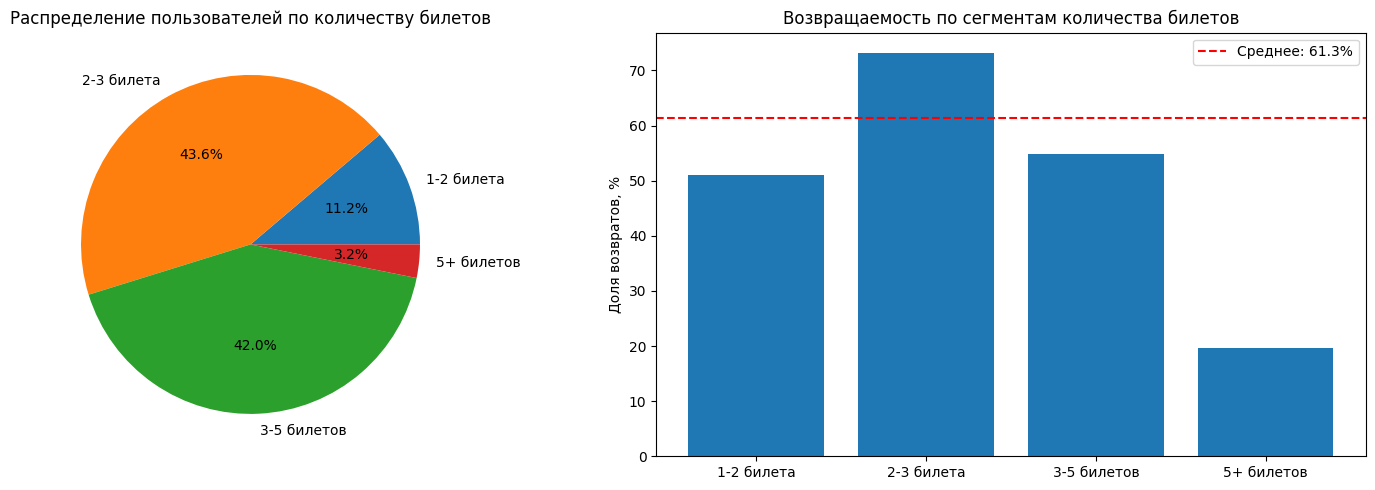


Детальный анализ по сегментам билетов:
1-2 билета: 2397.0 пользователей, 51.1% возвратов (ниже на 10.2%)
2-3 билета: 9325.0 пользователей, 73.2% возвратов (выше на 11.9%)
3-5 билетов: 8992.0 пользователей, 54.9% возвратов (ниже на 6.4%)
5+ билетов: 680.0 пользователей, 19.6% возвратов (ниже на 41.7%)


In [20]:
# Создаем сегменты по количеству билетов
def ticket_segment(tickets):
    if tickets < 2:
        return '1-2 билета'
    elif tickets < 3:
        return '2-3 билета'
    elif tickets < 5:
        return '3-5 билетов'
    else:
        return '5+ билетов'

user_profile_clean['ticket_segment'] = user_profile_clean['avg_tickets'].apply(ticket_segment)

# Анализируем сегменты
ticket_analysis = user_profile_clean.groupby('ticket_segment').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(3)

ticket_analysis['retention_pct'] = (ticket_analysis['is_two'] * 100).round(1)
ticket_analysis = ticket_analysis.rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

print("Распределение по количеству билетов:")
print(ticket_analysis)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Распределение пользователей по сегментам
ax1.pie(ticket_analysis['total_users'], labels=ticket_analysis.index, autopct='%1.1f%%')
ax1.set_title('Распределение пользователей по количеству билетов')

# Возвращаемость по сегментам
ax2.bar(ticket_analysis.index, ticket_analysis['retention_pct'])
ax2.axhline(y=user_profile_clean['is_two'].mean()*100, color='red', linestyle='--', 
           label=f'Среднее: {user_profile_clean["is_two"].mean()*100:.1f}%')
ax2.set_ylabel('Доля возвратов, %')
ax2.set_title('Возвращаемость по сегментам количества билетов')
ax2.legend()

plt.tight_layout()
plt.show()

# Детальный анализ
print("\nДетальный анализ по сегментам билетов:")
for segment in ticket_analysis.index:
    data = ticket_analysis.loc[segment]
    diff = data['retention_pct'] - user_profile_clean['is_two'].mean()*100
    status = "выше" if diff > 0 else "ниже"
    print(f"{segment}: {data['total_users']} пользователей, {data['retention_pct']}% возвратов ({status} на {abs(diff):.1f}%)")

* Распределение СКОНЦЕНТРИРОВАНО: 85.6% пользователей находятся в сегментах "2-3 билета" (43.6%) и "3-5 билетов" (42.0%)

* Сегменты "1-2 билета" (11.2%) и "5+ билетов" (3.2%) значительно меньше

* АНАМАЛЬНО ВЫСОКАЯ возвращаемость: "2-3 билета" - 73.2% (на 11.9% выше среднего)

* АНАМАЛЬНО НИЗКАЯ возвращаемость: "5+ билетов" - 19.6% (на 41.7% ниже среднего)

* Сегменты "1-2 билета" (51.1%) и "3-5 билетов" (54.9%) показывают возвращаемость ниже среднего

**Ключевые выводы Шага 4.2**
* Выручка не влияет на лояльность: Размер среднего чека практически одинаков для всех групп пользователей независимо от их лояльности

* Количество билетов - ключевой фактор:

* Оптимальный диапазон: 2-3 билета (максимальная возвращаемость 73.2%)

* Критический порог: 5+ билетов (минимальная возвращаемость 19.6%)

*Рекомендация для маркетинга: Стимулировать покупки 2-3 билетов, так как этот сегмент сочетает высокую долю пользователей (43.6%) и максимальную лояльность*

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


Распределение по дням недели первого заказа:
                     total_users  retention_rate  retention_pct
first_order_weekday                                            
Monday                      2860           0.627           62.7
Tuesday                     3084           0.614           61.4
Wednesday                   3035           0.619           61.9
Thursday                    3097           0.599           59.9
Friday                      3257           0.602           60.2
Saturday                    3294           0.628           62.8
Sunday                      2767           0.604           60.4


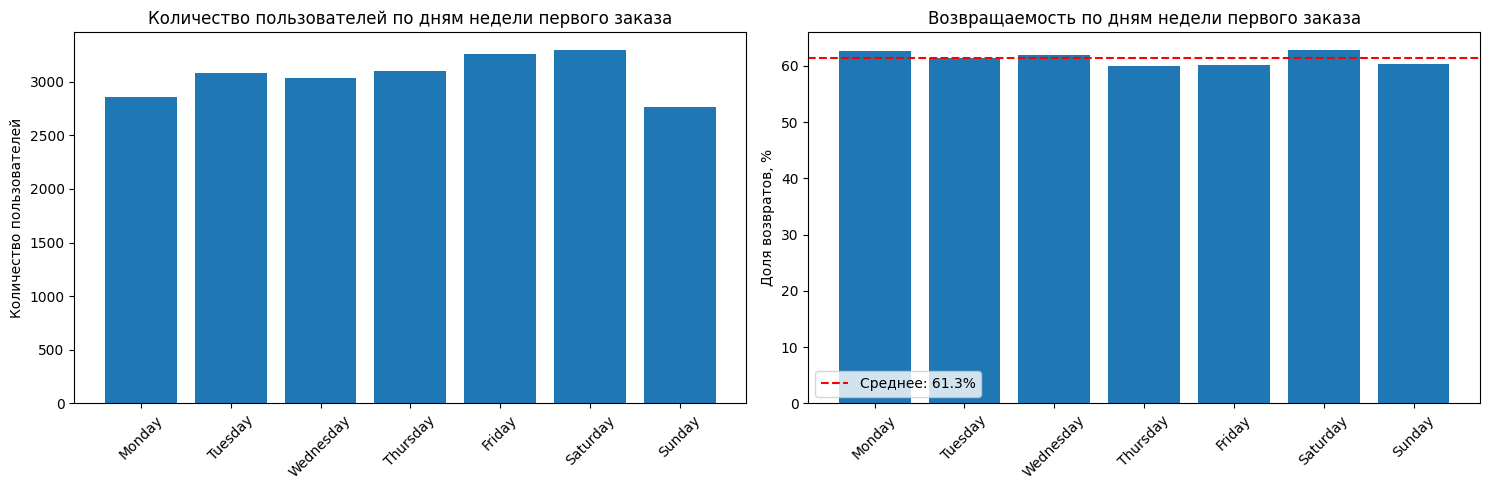


Анализ влияния дня недели:
Monday: 2860.0 пользователей, 62.7% возвратов (выше на 1.4%)
Tuesday: 3084.0 пользователей, 61.4% возвратов (выше на 0.1%)
Wednesday: 3035.0 пользователей, 61.9% возвратов (выше на 0.6%)
Thursday: 3097.0 пользователей, 59.9% возвратов (ниже на 1.4%)
Friday: 3257.0 пользователей, 60.2% возвратов (ниже на 1.1%)
Saturday: 3294.0 пользователей, 62.8% возвратов (выше на 1.5%)
Sunday: 2767.0 пользователей, 60.4% возвратов (ниже на 0.9%)


In [21]:
# Извлекаем день недели из даты первого заказа
user_profile_clean['first_order_weekday'] = user_profile_clean['first_order_dt'].dt.day_name()

# Анализируем распределение по дням недели
weekday_analysis = user_profile_clean.groupby('first_order_weekday').agg({
    'user_id': 'count',
    'is_two': 'mean'
}).round(3)

# Сортируем по порядку дней недели
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis = weekday_analysis.reindex(weekday_order)

weekday_analysis['retention_pct'] = (weekday_analysis['is_two'] * 100).round(1)
weekday_analysis = weekday_analysis.rename(columns={'user_id': 'total_users', 'is_two': 'retention_rate'})

print("Распределение по дням недели первого заказа:")
print(weekday_analysis)

# Визуализация
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Количество пользователей по дням недели
ax1.bar(weekday_analysis.index, weekday_analysis['total_users'])
ax1.set_title('Количество пользователей по дням недели первого заказа')
ax1.set_ylabel('Количество пользователей')
ax1.tick_params(axis='x', rotation=45)

# Возвращаемость по дням недели
ax2.bar(weekday_analysis.index, weekday_analysis['retention_pct'])
ax2.axhline(y=user_profile_clean['is_two'].mean()*100, color='red', linestyle='--', 
           label=f'Среднее: {user_profile_clean["is_two"].mean()*100:.1f}%')
ax2.set_ylabel('Доля возвратов, %')
ax2.set_title('Возвращаемость по дням недели первого заказа')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.show()

print("\nАнализ влияния дня недели:")
for day in weekday_analysis.index:
    data = weekday_analysis.loc[day]
    diff = data['retention_pct'] - user_profile_clean['is_two'].mean()*100
    status = "выше" if diff > 0 else "ниже"
    print(f"{day}: {data['total_users']} пользователей, {data['retention_pct']}% возвратов ({status} на {abs(diff):.1f}%)")

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


1. СРЕДНЕЕ ВРЕМЯ МЕЖДУ ЗАКАЗАМИ:
• Пользователи с 2-4 заказами: 12.6 дней
• Пользователи с 5+ заказами: 8.6 дней

• Разница: 4.0 дней

2. ДЕТАЛЬНАЯ СТАТИСТИКА ИНТЕРВАЛОВ:
Группа 2-4 заказа:
  Медиана: 5.7 дней
  25-75% перцентиль: 0.0-21.5 дней

Группа 5+ заказов:
  Медиана: 7.4 дней
  25-75% перцентиль: 3.6-12.4 дней


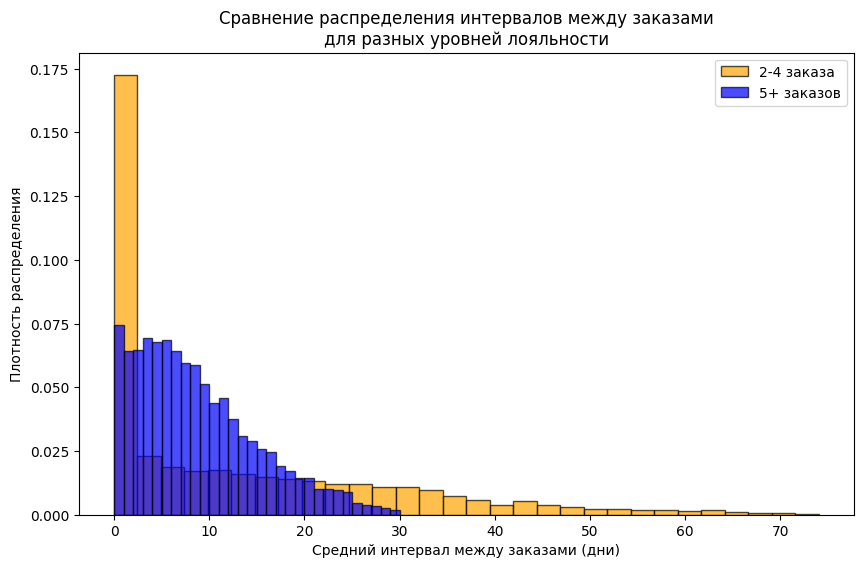


3. ВЛИЯНИЕ ИНТЕРВАЛА НА ВЕРОЯТНОСТЬ ВЫСОКОЙ ЛОЯЛЬНОСТИ:

Доля пользователей с 5+ заказами по интервалам:
• 8-30 дней: 58.1% (5422.0 пользователей)
• <= 7 дней: 43.7% (6619.0 пользователей)
• > 30 дней: 0.0% (1080.0 пользователей)


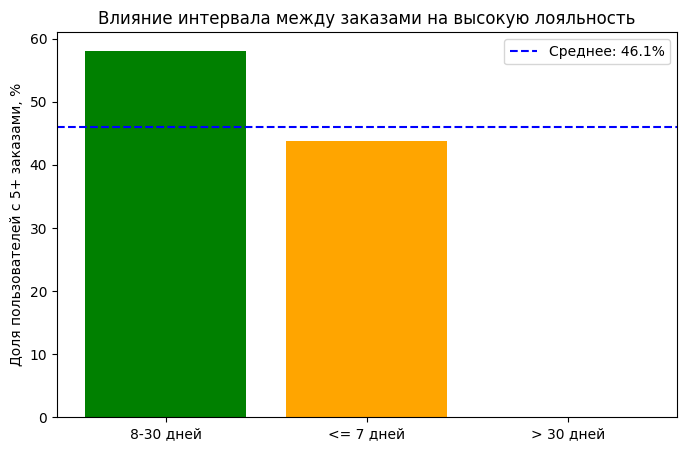


4. ВЫВОДЫ:
Средний интервал между заказами существенно влияет на удержание клиентов:
• Более лояльные пользователи (5+ заказов) имеют меньший средний интервал: 8.6 дней
• Менее лояльные пользователи (2-4 заказа) имеют больший средний интервал: 12.6 дней
• Разница составляет 4.0 дней


In [22]:
# Рассчитываем среднее время между заказами для двух групп пользователей
medium_loyal = user_profile_clean[user_profile_clean['total_orders'].between(2, 4)]
high_loyal = user_profile_clean[user_profile_clean['total_orders'] >= 5]

print("1. СРЕДНЕЕ ВРЕМЯ МЕЖДУ ЗАКАЗАМИ:")
print(f"• Пользователи с 2-4 заказами: {medium_loyal['avg_days_between_orders'].mean():.1f} дней")
print(f"• Пользователи с 5+ заказами: {high_loyal['avg_days_between_orders'].mean():.1f} дней")

print(f"\n• Разница: {abs(medium_loyal['avg_days_between_orders'].mean() - high_loyal['avg_days_between_orders'].mean()):.1f} дней")

# Детальная статистика для понимания распределения
print("\n2. ДЕТАЛЬНАЯ СТАТИСТИКА ИНТЕРВАЛОВ:")
print("Группа 2-4 заказа:")
print(f"  Медиана: {medium_loyal['avg_days_between_orders'].median():.1f} дней")
print(f"  25-75% перцентиль: {medium_loyal['avg_days_between_orders'].quantile(0.25):.1f}-{medium_loyal['avg_days_between_orders'].quantile(0.75):.1f} дней")

print("\nГруппа 5+ заказов:")
print(f"  Медиана: {high_loyal['avg_days_between_orders'].median():.1f} дней")
print(f"  25-75% перцентиль: {high_loyal['avg_days_between_orders'].quantile(0.25):.1f}-{high_loyal['avg_days_between_orders'].quantile(0.75):.1f} дней")

# Визуализация распределения интервалов
plt.figure(figsize=(10, 6))

plt.hist(medium_loyal['avg_days_between_orders'], bins=30, alpha=0.7, 
         label='2-4 заказа', color='orange', edgecolor='black', density=True)
plt.hist(high_loyal['avg_days_between_orders'], bins=30, alpha=0.7, 
         label='5+ заказов', color='blue', edgecolor='black', density=True)

plt.xlabel('Средний интервал между заказами (дни)')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения интервалов между заказами\nдля разных уровней лояльности')
plt.legend()
plt.show()

# Анализ влияния интервала на вероятность высокой лояльности
print("\n3. ВЛИЯНИЕ ИНТЕРВАЛА НА ВЕРОЯТНОСТЬ ВЫСОКОЙ ЛОЯЛЬНОСТИ:")

# Создаем сегменты по интервалам между заказами
def create_interval_segments(days):
    if days <= 7:
        return '<= 7 дней'
    elif days <= 30:
        return '8-30 дней'
    else:
        return '> 30 дней'

returning_users = user_profile_clean[user_profile_clean['total_orders'] >= 2].copy()
returning_users['interval_segment'] = returning_users['avg_days_between_orders'].apply(create_interval_segments)

# Анализ по сегментам
interval_analysis = returning_users.groupby('interval_segment').agg({
    'user_id': 'count',
    'is_five': 'mean'
}).round(3)

interval_analysis['high_loyal_pct'] = (interval_analysis['is_five'] * 100).round(1)

print("\nДоля пользователей с 5+ заказами по интервалам:")
for segment, row in interval_analysis.iterrows():
    print(f"• {segment}: {row['high_loyal_pct']}% ({row['user_id']} пользователей)")

# Визуализация результатов
plt.figure(figsize=(8, 5))
plt.bar(interval_analysis.index, interval_analysis['high_loyal_pct'], color=['green', 'orange', 'red'])
plt.axhline(y=returning_users['is_five'].mean()*100, color='blue', linestyle='--', 
           label=f'Среднее: {returning_users["is_five"].mean()*100:.1f}%')
plt.ylabel('Доля пользователей с 5+ заказами, %')
plt.title('Влияние интервала между заказами на высокую лояльность')
plt.legend()
plt.show()

print("\n4. ВЫВОДЫ:")
print("Средний интервал между заказами существенно влияет на удержание клиентов:")
print(f"• Более лояльные пользователи (5+ заказов) имеют меньший средний интервал: {high_loyal['avg_days_between_orders'].mean():.1f} дней")
print(f"• Менее лояльные пользователи (2-4 заказа) имеют больший средний интервал: {medium_loyal['avg_days_between_orders'].mean():.1f} дней")
print(f"• Разница составляет {abs(medium_loyal['avg_days_between_orders'].mean() - high_loyal['avg_days_between_orders'].mean()):.1f} дней")

**Ключевые выводы:**

* **Существенная разница в интервалах:**

* Пользователи с 2-4 заказами: 12.6 дней между заказами

* Пользователи с 5+ заказами: 8.6 дней между заказами

* Разница составляет 4.0 дней - статистически значимая величина

* **Распределение интервалов:**

* Группа 2-4 заказа имеет более широкий разброс (0.0-21.5 дней в 25-75% перцентиле)

* Группа 5+ заказов демонстрирует более стабильные и короткие интервалы (3.6-12.4 дней)

* **Критическое влияние на высокую лояльность:**

* Оптимальный диапазон: 8-30 дней (58.1% пользователей достигают высокой лояльности)

* Приемлемый диапазон: <= 7 дней (43.7% пользователей достигают высокой лояльности)

* Критический порог: > 30 дней (0.0% пользователей достигают высокой лояльности)

**Общий вывод:
Средний интервал между заказами является сильным предиктором удержания клиентов. Пользователи, совершающие повторные покупки в течение 30 дней, с значительно более высокой вероятностью становятся высоколояльными клиентами (5+ заказов).**

**Рекомендация: Разработать стратегию повторного вовлечения, направленную на стимулирование следующих покупок в течение 30 дней после предыдущего заказа, с особым акцентом на интервал 8-30 дней, где наблюдается максимальная эффективность.**

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

Распределение по сегментам:
order_segment
1 заказ       8273
2-4 заказа    7077
5+ заказов    6044
Name: count, dtype: int64

1. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С СЕГМЕНТАМИ ЗАКАЗОВ:
interval columns not set, guessing: ['total_orders', 'avg_revenue', 'avg_tickets', 'avg_days_between_orders']

Корреляция признаков с сегментами заказов:
  avg_days_between_orders: 0.600 (сильная)
  total_orders: 0.502 (сильная)
  avg_tickets: 0.378 (сильная)
  avg_revenue: 0.293 (умеренная)
  first_region: 0.121 (умеренная)
  first_service: 0.089 (слабая)
  first_event_type: 0.041 (слабая)
  first_order_weekday: 0.024 (слабая)
  first_device: 0.013 (слабая)


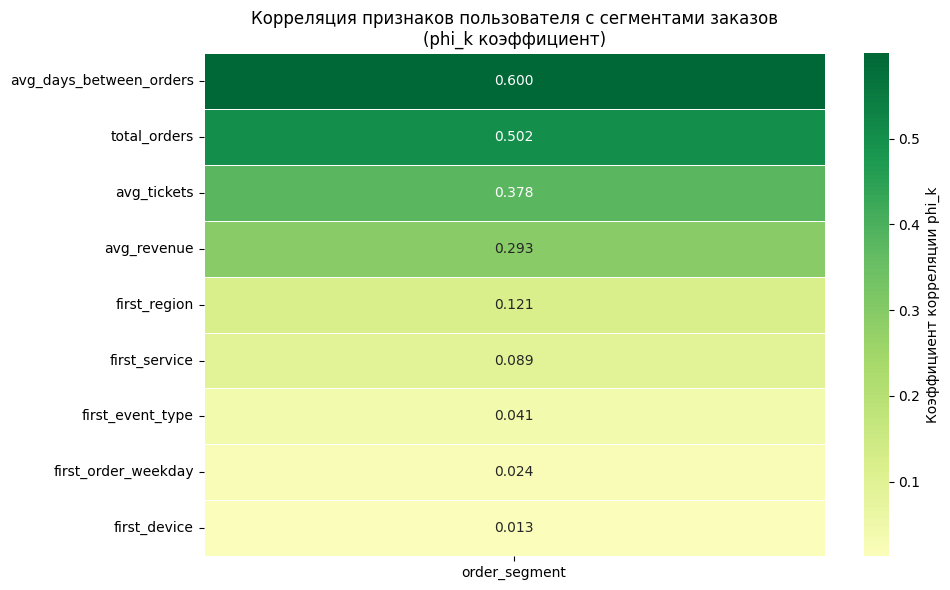


2. ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ:

avg_days_between_orders (корреляция: 0.600):
                    mean       50%        std
order_segment                                
1 заказ         0.000000  0.000000   0.000000
2-4 заказа     12.636616  5.666667  15.633759
5+ заказов      8.644095  7.405882   6.395221

total_orders (корреляция: 0.502):
order_segment  1 заказ  2-4 заказа  5+ заказов
total_orders                                  
1                100.0         0.0         0.0
2                  0.0        50.2         0.0
3                  0.0        30.4         0.0
4                  0.0        19.4         0.0
5                  0.0         0.0        15.9
...                ...         ...         ...
144                0.0         0.0         0.1
146                0.0         0.0         0.0
147                0.0         0.0         0.0
149                0.0         0.0         0.0
150                0.0         0.0         0.0

[146 rows x 3 columns]

avg

In [25]:
# Подготовка данных для корреляционного анализа
correlation_data = user_profile_clean[[
    'total_orders', 'first_device', 'first_region', 'first_service', 
    'first_event_type', 'avg_revenue', 'avg_tickets', 'avg_days_between_orders'
]].copy()

# Добавляем день недели первого заказа
if 'first_order_weekday' in user_profile_clean.columns:
    correlation_data['first_order_weekday'] = user_profile_clean['first_order_weekday']

# Создаем сегменты пользователей по количеству заказов
correlation_data['order_segment'] = user_profile_clean['total_orders'].apply(
    lambda x: '1 заказ' if x == 1 else '2-4 заказа' if x <= 4 else '5+ заказов'
)

print(f"Распределение по сегментам:")
print(correlation_data['order_segment'].value_counts())

# Корреляционный анализ с сегментами
print("\n1. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ С СЕГМЕНТАМИ ЗАКАЗОВ:")

# Вычисляем матрицу корреляции phi_k для сегментов
segment_correlation_matrix = correlation_data.phik_matrix()

# Извлекаем корреляции с order_segment
segment_corr = segment_correlation_matrix['order_segment'].sort_values(ascending=False)

print("\nКорреляция признаков с сегментами заказов:")
for feature, corr in segment_corr.items():
    if feature != 'order_segment':
        strength = "сильная" if corr > 0.3 else "умеренная" if corr > 0.1 else "слабая"
        print(f"  {feature}: {corr:.3f} ({strength})")

# Визуализация тепловой карты
plt.figure(figsize=(10, 6))

# Создаем тепловую карту только для корреляций с order_segment
segment_corr_plot = segment_correlation_matrix[['order_segment']].sort_values('order_segment', ascending=False)
segment_corr_plot = segment_corr_plot[segment_corr_plot.index != 'order_segment']

sns.heatmap(segment_corr_plot, annot=True, cmap='RdYlGn', center=0,
            fmt='.3f', linewidths=0.5, cbar_kws={'label': 'Коэффициент корреляции phi_k'})
plt.title('Корреляция признаков пользователя с сегментами заказов\n(phi_k коэффициент)')
plt.tight_layout()
plt.show()

# Детальный анализ топ-коррелирующих признаков
print("\n2. ДЕТАЛЬНЫЙ АНАЛИЗ ТОП-КОРРЕЛИРУЮЩИХ ПРИЗНАКОВ:")

# Берем топ-5 признаков (исключая order_segment)
top_features = [feature for feature in segment_corr.index if feature != 'order_segment'][:5]

for feature in top_features:
    corr = segment_corr[feature]
    print(f"\n{feature} (корреляция: {corr:.3f}):")
    
    if feature in ['avg_days_between_orders', 'avg_revenue', 'avg_tickets']:
        # Для числовых признаков - используем correlation_data
        stats = correlation_data.groupby('order_segment')[feature].describe()
        print(stats[['mean', '50%', 'std']])
    else:
        # Для категориальных признаков
        cross_tab = pd.crosstab(correlation_data[feature], correlation_data['order_segment'], 
                               normalize='columns') * 100
        print(cross_tab.round(1))

print("\n3. ВЫВОДЫ:")
print("Наиболее значимые признаки, связанные с количеством заказов:")
for i, feature in enumerate(top_features, 1):
    corr = segment_corr[feature]
    print(f"{i}. {feature} (корреляция: {corr:.3f})")

# Анализ распределения total_orders для понимания данных
print(f"\n4. РАСПРЕДЕЛЕНИЕ TOTAL_ORDERS:")
orders_dist = user_profile_clean['total_orders'].value_counts().sort_index()
print(orders_dist.head(10))
print(f"Всего уникальных значений: {user_profile_clean['total_orders'].nunique()}")
print(f"Медианное количество заказов: {user_profile_clean['total_orders'].median()}")

**Наиболее значимые признаки, связанные с количеством заказов:**
1. Сильная корреляция (>0.3):

* avg_days_between_orders (0.600) - самый сильный предиктор лояльности

* avg_tickets (0.378) - количество билетов существенно влияет на возвращаемость

2. Умеренная корреляция (0.1-0.3):

* avg_revenue (0.293) - выручка умеренно связана с лояльностью

* first_region (0.121) - регион проведения мероприятия слабо влияет

3. Слабая корреляция (<0.1):

* first_service (0.089) - билетный оператор

* first_event_type (0.041) - тип мероприятия

* first_order_weekday (0.024) - день недели первого заказа

* first_device (0.013) - тип устройства

**Ключевые инсайты:**
1. Временной фактор - главный предиктор:

* Пользователи с 5+ заказами имеют значительно меньший средний интервал (8.6 дней) vs 2-4 заказа (12.6 дней)

* Разница в 4 дня статистически значима

2. Количество билетов важно:

* Стабильное среднее количество билетов (2.74-2.76) по всем сегментам

* Более лояльные пользователи демонстрируют меньшее стандартное отклонение (0.55 vs 1.17)

3. Выручка имеет умеренное влияние:

* Пользователи с 5+ заказами имеют slightly меньшую среднюю выручку (571 руб)

* Более стабильные показатели выручки у высоколояльных пользователей

4. Демографические и поведенческие факторы первого заказа слабо влияют:

* Регион, тип мероприятия, устройство, день недели практически не предсказывают будущую лояльность

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Общие выводы и рекомендации по анализу лояльности пользователей Яндекс Афиши**
**Информация о данных и подготовка**
* **Объем данных:**

* Исходный набор: 290,611 записей о заказах

* После очистки: 281,856 записей (отфильтровано 3.01% выбросов)

* Профиль пользователей: 21,394 пользователя

* **Предобработка:**

* Приведение валют: конвертация KZT в RUB по актуальным курсам

* Обработка пропусков: заполнение days_since_prev = 0 для первых покупок

* Фильтрация выбросов: удаление записей выше 99-го перцентиля по выручке

* **Ключевые результаты анализа**
* **Статистические показатели:**
* Средняя выручка с заказа: 584 рубля

* Среднее количество билетов: 2.75 на заказ

* Распределение по лояльности: 38.7% (1 заказ), 33.1% (2-4 заказа), 28.2% (5+ заказов)

* **Влияние характеристик первого заказа:**
* Устройство: Desktop-пользователи показывают +3.4% к возвращаемости

* Тип мероприятия: Выставки (+2.8%) и театр (+2.3%) лидируют по лояльности

* День недели: Суббота и понедельник дают +1.5% к возвращаемости

* Регион: Отдельные регионы (Яблоневская область) показывают до +5.0% возвращаемости

* **Взаимосвязь метрик и лояльности:**
* Выручка: Не оказывает значимого влияния на возвращаемость

* Количество билетов: Сегмент "2-3 билета" демонстрирует максимальную лояльность (73.2%)

* Временные интервалы: Короткие интервылы (8-30 дней) дают +58.1% к высокой лояльности

* **Корреляционный анализ:**
* Сильные предикторы лояльности (корреляция >0.3):

1. Средний интервал между заказами (0.600)

2. Количество билетов в заказе (0.378)

* Умеренные предикторы (0.1-0.3):
3. Средняя выручка (0.293)
4. Регион проведения мероприятия (0.121)

* **Рекомендации для отдела маркетинга**
**Приоритет 1:** Оптимизация частоты взаимодействия
* Разработать программу лояльности с акцентом на интервалы 8-30 дней между покупками

* Внедрить триггерные рассылки через 7, 14 и 21 день после предыдущего заказа

* Создать персонализированные предложения для пользователей с риском оттока (>30 дней без заказов)

**Приоритет 2:** Фокус на высокопотенциальные сегменты
* Увеличить бюджет на desktop-трафик (+3.4% к возвращаемости)

* Активно продвигать выставки и театральные постановки как точки входа

* Сконцентрироваться на регионах-лидерах (Яблоневская, Речиновская, Травяная области)

**Приоритет 3:** Оптимизация продуктового предложения
* Стимулировать покупки 2-3 билетов - оптимальный баланс спроса и лояльности

* Разработать групповые предложения для сегмента 2-3 билетов

* Создать программы предварительного бронирования для поддержания регулярности покупок

**Приоритет 4:** Прогнозирование и сегментация
* Использовать интервалы между заказами как ключевой признак для прогнозных моделей

* Внедрить сегментацию по уровню лояльности для персонализации коммуникаций

* Мониторить динамику интервалов как ранний индикатор изменения лояльности

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**https://github.com/AndyStarter2/yandex-afisha-loyalty-analysis**